<a href="https://colab.research.google.com/github/Qwecie/CarCare-Ai/blob/main/CDU_Opt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install gymnasium stable-baselines3 matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

Saving to Drive

In [6]:
from google.colab import drive
drive.mount('/content/drive/slow')


Mounted at /content/drive/slow


Adding the crude_env environment

In [4]:
%%writefile crude_env.py
import numpy as np
import gymnasium as gym
from gymnasium import spaces

class CrudeDistillationEnv(gym.Env):
    def __init__(self):
        super(CrudeDistillationEnv, self).__init__()
        self.feed_rate = 60000
        self.action_space = spaces.Box(
            low=np.array([-0.5, -0.1, -5.0, -0.2], dtype=np.float32),
            high=np.array([0.5, 0.1, 5.0, 0.2], dtype=np.float32)
        )
        self.observation_space = spaces.Box(
            low=np.array([1.0, 0.5, 100.0, 0.5, 0.0, 0.0], dtype=np.float32),
            high=np.array([6.0, 4.0, 200.0, 2.0, self.feed_rate, self.feed_rate], dtype=np.float32)
        )
        self.max_steps = 100
        self.current_step = 0
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.reboiler_duty = 3.0
        self.reflux_ratio = 1.5
        self.feed_temp = 120.0
        self.pressure = 1.0
        self.current_step = 0
        top_yield, bottom_yield = self._calculate_yields()
        return np.array([self.reboiler_duty, self.reflux_ratio, self.feed_temp,
                         self.pressure, top_yield, bottom_yield], dtype=np.float32), {}

    def step(self, action):
        self.current_step += 1
        self.reboiler_duty += float(action[0])
        self.reflux_ratio += float(action[1])
        self.feed_temp += float(action[2])
        self.pressure += float(action[3])
        self.reboiler_duty = float(np.clip(self.reboiler_duty, 1.0, 6.0))
        self.reflux_ratio = float(np.clip(self.reflux_ratio, 0.5, 4.0))
        self.feed_temp = float(np.clip(self.feed_temp, 100.0, 200.0))
        self.pressure = float(np.clip(self.pressure, 0.5, 2.0))
        top_yield, bottom_yield = self._calculate_yields()
        top_frac = top_yield / self.feed_rate
        reward = (-100 * (top_frac - 0.4) ** 2 - 0.1 * self.reboiler_duty - 0.05 * self.reflux_ratio)
        obs = np.array([self.reboiler_duty, self.reflux_ratio, self.feed_temp,
                        self.pressure, top_yield, bottom_yield], dtype=np.float32)
        return obs, reward, False, self.current_step >= self.max_steps, {"top_frac": top_frac, "reward": reward}

    def _calculate_yields(self):
        efficiency = min(1.0, max(0.1, 0.3 + 0.1 * (self.reflux_ratio - 1.0)))
        temp_factor = np.clip((self.feed_temp - 100) / 100, 0.0, 1.0)
        pressure_factor = 1.0 - abs(self.pressure - 1.0) * 0.5
        top_frac = efficiency * temp_factor * pressure_factor
        top_yield = top_frac * self.feed_rate
        bottom_yield = self.feed_rate - top_yield
        return top_yield, bottom_yield


Writing crude_env.py


In [5]:
import importlib
import crude_env
importlib.reload(crude_env)
from crude_env import CrudeDistillationEnv


In [6]:
class PIDController:
    def __init__(self, Kp, Ki, Kd, setpoint=0.4):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.setpoint = setpoint

        self.integral = 0
        self.prev_error = 0

    def compute(self, measurement):
        error = self.setpoint - measurement
        self.integral += error
        derivative = error - self.prev_error

        output = self.Kp * error + self.Ki * self.integral + self.Kd * derivative
        self.prev_error = error
        return output


Run the PID Controller

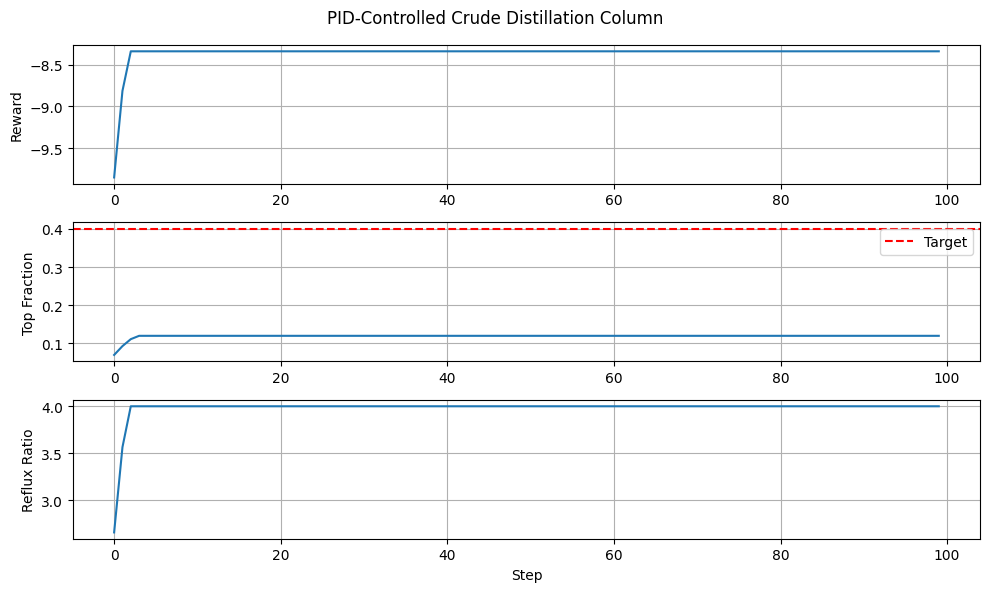

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize the environment and PID controller
env = CrudeDistillationEnv()
pid = PIDController(Kp=2.0, Ki=0.5, Kd=1.0)  # You can tune these values

obs, _ = env.reset()
rewards, top_fracs, reflux_log = [], [], []

# Run the PID control loop for 100 steps
for _ in range(100):
    top_frac = obs[4] / env.feed_rate  # Calculate actual top fraction
    delta_reflux = pid.compute(top_frac)

    action = np.array([0.0, delta_reflux, 0.0, 0.0], dtype=np.float32)  # Only change reflux
    obs, reward, terminated, truncated, info = env.step(action)

    rewards.append(reward)
    top_fracs.append(top_frac)
    reflux_log.append(obs[1])  # Reflux ratio

# Plotting
plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.plot(rewards)
plt.ylabel("Reward")
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(top_fracs)
plt.ylabel("Top Fraction")
plt.axhline(0.4, color='r', linestyle='--', label='Target')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(reflux_log)
plt.ylabel("Reflux Ratio")
plt.xlabel("Step")
plt.grid(True)

plt.suptitle("PID-Controlled Crude Distillation Column")
plt.tight_layout()
plt.show()


Creating an agent

In [11]:


# Create checkpoint directory
import os
checkpoint_path = "/content/drive/MyDrive/ppo_crude_checkpoints"
os.makedirs(checkpoint_path, exist_ok=True)

# Import libraries
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import CheckpointCallback

# Import your custom environment
from crude_env import CrudeDistillationEnv

# Initialize and validate environment
env = CrudeDistillationEnv()
check_env(env, warn=True)

# Wrap with monitor for logging
monitored_env = Monitor(env)

# Create PPO model
model = PPO(
    policy="MlpPolicy",
    env=monitored_env,
    verbose=1,
    learning_rate=0.00009,
    clip_range=0.09,
    gamma=0.99,
    n_steps=2048,
    batch_size=64,
    tensorboard_log="/content/ppo_crude_tensorboard/"
)

# Set up checkpoint callback (save every 100,000 steps)
checkpoint_callback = CheckpointCallback(
    save_freq=100_000,
    save_path=checkpoint_path,
    name_prefix="ppo_crude"
)

# Start training
model.learn(
    total_timesteps=500_000,
    callback=checkpoint_callback
)

# Final model save
model.save(f"{checkpoint_path}/ppo_crude_final")
print("✅ Training complete. Final model saved.")



Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to /content/ppo_crude_tensorboard/PPO_2


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/env_checker.py:462: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


Streaming output truncated to the last 5000 lines.
|    n_updates            | 170          |
|    policy_gradient_loss | -0.00411     |
|    std                  | 0.999        |
|    value_loss           | 1.06e+04     |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -697         |
| time/                   |              |
|    fps                  | 863          |
|    iterations           | 19           |
|    time_elapsed         | 45           |
|    total_timesteps      | 38912        |
| train/                  |              |
|    approx_kl            | 0.0014450414 |
|    clip_fraction        | 0.0874       |
|    clip_range           | 0.09         |
|    entropy_loss         | -5.68        |
|    explained_variance   | 0.000734     |
|    learning_rate        | 9e-05        |
|    loss                 | 3.78e+03     |
|  

Visualise agent performance

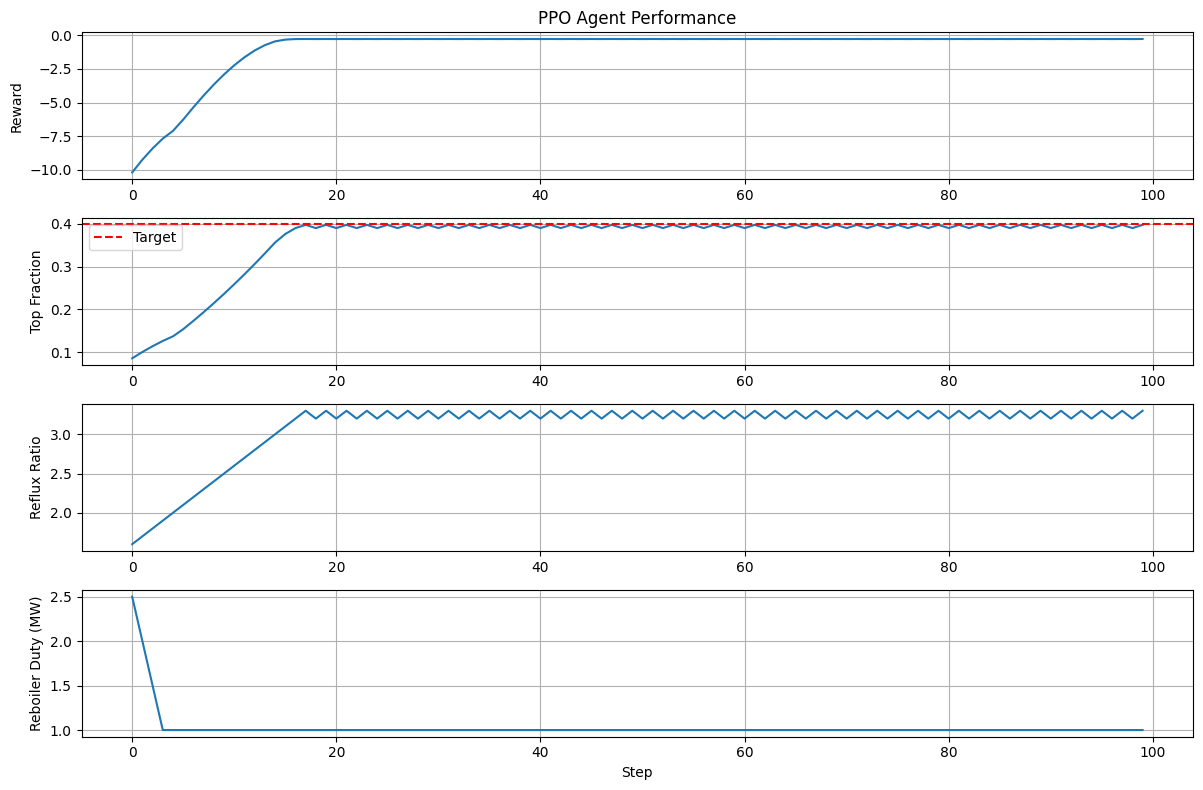

In [12]:
env = CrudeDistillationEnv()
# model = PPO.load("/content/drive/MyDrive/ppo_crude_models/ppo_crude_final")

obs, _ = env.reset()
rewards, top_fracs, refluxes, duties = [], [], [], []

for _ in range(100):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)

    rewards.append(reward)
    top_fracs.append(info["top_frac"])
    refluxes.append(obs[1])       # reflux ratio
    duties.append(obs[0])         # reboiler duty

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(rewards)
plt.ylabel("Reward")
plt.title("PPO Agent Performance")
plt.grid(True)

plt.subplot(4, 1, 2)
plt.plot(top_fracs)
plt.axhline(0.4, color='r', linestyle='--', label='Target')
plt.ylabel("Top Fraction")
plt.legend()
plt.grid(True)

plt.subplot(4, 1, 3)
plt.plot(refluxes)
plt.ylabel("Reflux Ratio")
plt.grid(True)

plt.subplot(4, 1, 4)
plt.plot(duties)
plt.ylabel("Reboiler Duty (MW)")
plt.xlabel("Step")
plt.grid(True)

plt.tight_layout()
plt.show()
